In [1]:
!ls

classifiers_mhcld.ipynb
codebook_descriptions.pickle
deep_learning.ipynb
google_colab_t-sne_mental_health_client-level_data.ipynb
mhcld_puf_2021.csv
plots
t-sne_k-means_mhcld.ipynb
to_do.txt
unsupervised_learning.ipynb


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
NUM_POINTS = 100_000
data = pd.read_csv("mhcld_puf_2021.csv")
data = data[:NUM_POINTS]

In [4]:
# Load data the codebook descriptions
import pickle
with open('codebook_descriptions.pickle', 'rb') as handle:
    codebook_descriptions = pickle.load(handle)
assert set(list(data.columns)) == set(list(codebook_descriptions.keys()))

In [5]:
#columns to drop. reasoning in t-sne notebook.
drop_cols = ['YEAR','CASEID','SUB','MH1','MH2','MH3','SMISED','DETNLF','NUMMHS','STATEFIP','REGION','DIVISION']
data = data.drop(columns = drop_cols)

In [6]:
#disorder columns. 0/1 binary. these are dignoses for the disorders
disorder_cols = ['TRAUSTREFLG','ANXIETYFLG','ADHDFLG','CONDUCTFLG','DELIRDEMFLG','BIPOLARFLG','DEPRESSFLG','ODDFLG','PDDFLG','SCHIZOFLG','PERSONFLG','ALCSUBFLG','OTHERDISFLG']

In [7]:
#columns which require a transformation to standardize to 0-1. reasoning in t-sne notebook.
transform_cols = ['AGE','EDUC','GENDER','SPHSERVICE','CMPSERVICE','OPISERVICE','RTCSERVICE','IJSSERVICE','SAP','VETERAN ']
max_age = max(data['AGE'])
max_educ = max(data['EDUC'])
data['AGE'] = data['AGE'].apply(lambda x: x/max_age)
data['EDUC'] = data['EDUC'].apply(lambda x: 0 if x==-9 else x/max_educ)
data['GENDER'] = data['GENDER'].apply(lambda x: .5 if x==-9 else x-1)
data['SAP'] = data['SAP'].apply(lambda x: .5 if x==-9 else x-1)
data['VETERAN'] = data['VETERAN'].apply(lambda x: .5 if x==-9 else x-1)
data['SPHSERVICE'] = data['SPHSERVICE'].apply(lambda x: x-1)
data['CMPSERVICE'] = data['CMPSERVICE'].apply(lambda x: x-1)
data['OPISERVICE'] = data['OPISERVICE'].apply(lambda x: x-1)
data['RTCSERVICE'] = data['RTCSERVICE'].apply(lambda x: x-1)
data['IJSSERVICE'] = data['IJSSERVICE'].apply(lambda x: x-1)

In [8]:
#categorical columns w/ more than two categorices
#encode them with one-hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_cols = ['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']
one_hot_enc=OneHotEncoder().fit(data[one_hot_cols])
one_hot_categorical_data = one_hot_enc.transform(data[one_hot_cols]).toarray()
one_hot_feature_names=list(one_hot_enc.get_feature_names_out(['ETHNIC','RACE','MARSTAT','EMPLOY','LIVARAG']))
one_hot_encoded_df = pd.DataFrame(data=one_hot_categorical_data,columns=one_hot_feature_names)
print(sum(len(item) for item in one_hot_enc.categories_))
data = data.drop(columns=one_hot_cols)
data = data.join(one_hot_encoded_df)
print(data.shape)

26
(100000, 49)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [21]:
model = Sequential()
model.add(Dense(10, input_shape=(36,), activation='relu'))
model.add(Dense(13, activation='relu'))

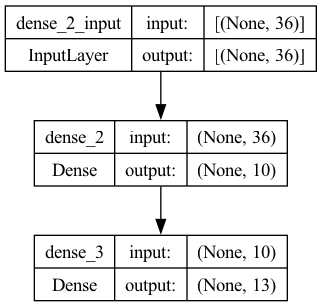

In [22]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
#drop disorder cols, we are predicting those
#use unique_disorder labels
X = data.drop(columns=disorder_cols)
y = np.squeeze(data[disorder_cols])

In [20]:
print(X.shape, y.shape)

(100000, 36) (100000, 13)


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Split the data into training and test sets
#stratified k-fold didn't help much
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
# fit the keras model on the dataset
model.fit(X, y, epochs=2, batch_size=10)

Epoch 1/2
10000/10000 [==============================] - 46s 5ms/step - loss: 0.3195 - accuracy: 0.3506
Epoch 2/2
10000/10000 [==============================] - 46s 5ms/step - loss: 0.3192 - accuracy: 0.3526


In [29]:
model.predict(X_test.iloc[0])

ValueError: in user code:

    File "/Users/jacksonwalters/venv-metal/lib/python3.9/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/Users/jacksonwalters/venv-metal/lib/python3.9/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/jacksonwalters/venv-metal/lib/python3.9/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/jacksonwalters/venv-metal/lib/python3.9/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/Users/jacksonwalters/venv-metal/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/jacksonwalters/venv-metal/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 36, but received input with shape (None, 1)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
      • training=False
      • mask=None
